In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [170]:
file_path = '/content/drive/MyDrive/論文資料/Quantity & Yield.csv'
df = pd.read_csv(file_path)

In [171]:
df=df.dropna()

In [172]:
df

,Year,CornYield,CornYield Growth Rate,Soybean Yield,SoybeanYield Growth Rate,Wheat Yield,Wheat Yield Growth Rate,Corn Quantity,Corn Quantity Growth Rate,Corn_ONI,Soybean Quantity,Soybean Quantity Growth Rate,Soybean_ONI,Wheat Quantity,Wheat Quantity Growth Rate,Wheat_ONI,lag_corn_quantity_rate,lag_wheat_yield_rate,lag_soybean_yield_rate
2,1963,4259.6,0.048620,1643.2,0.007974,1694.9,0.008329,102093008,0.114504,0.62,19028000,0.044748,0.80,31211888,0.050269,-0.0875,0.002364,0.045986,-0.035385
3,1964,3949.8,-0.072730,1530.9,-0.068342,1734.4,0.023305,88504000,-0.133104,-0.56,19076000,0.002523,-0.66,34928000,0.119061,0.6125,0.114504,0.008329,0.007974
4,1965,4649.2,0.177072,1650.8,0.078320,1785.3,0.029347,104216928,0.177539,0.84,23014000,0.206437,1.18,35805008,0.025109,-0.3375,-0.133104,0.023305,-0.068342
5,1966,4589.2,-0.012905,1708.7,0.035074,1768.8,-0.009242,105861408,0.015779,0.32,25270000,0.098027,0.16,35513856,-0.008132,1.3000,0.177539,0.029347,0.078320
6,1967,5026.5,0.095289,1649.8,-0.034471,1737.5,-0.017696,123458304,0.166226,-0.16,26574768,0.051633,-0.14,41030784,0.155346,-0.3250,0.015779,-0.009242,0.035074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2019,10510.4,-0.050945,3187.5,-0.062417,3474.6,0.085643,345962110,-0.050239,0.42,96667090,-0.197880,0.32,52580890,0.024858,0.7250,-0.018415,0.026624,0.026077
59,2020,10760.5,0.023795,3432.7,0.076925,3341.7,-0.038249,358447310,0.036088,-0.24,114748940,0.187053,-0.46,49751180,-0.053816,0.3500,-0.050239,0.085643,-0.062417
60,2021,11091.2,0.030733,3478.6,0.013371,2980.5,-0.108089,381469380,0.064227,-0.50,121503600,0.058865,-0.50,44803690,-0.099445,-0.9500,0.036088,-0.038249,0.076925
61,2022,10886.3,-0.018474,3332.6,-0.041971,3126.5,0.048985,346739460,-0.091042,-0.94,116220720,-0.043479,-0.92,44897830,0.002101,-0.9750,0.064227,-0.108089,0.013371


# 玉米

In [173]:
# 2. 設定玉米欄位名
y_col = 'Corn Quantity Growth Rate'
y_lag1_col = 'lag_corn_quantity_rate'
thresh_col = 'Corn_ONI'

data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
print(f"玉米資料數：{len(data)}")

玉米資料數：61


In [174]:
# 3. Grid search 找門檻
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

sse_list = np.array(sse_list)
if np.all(np.isnan(sse_list)):
    print("❗ 沒有合格的 regime 分割（樣本數限制），請調低門檻或檢查資料。")
else:
    min_sse = np.nanmin(sse_list)
    best_thr = candidate_thresholds[np.nanargmin(sse_list)]
    print(f"玉米最小SSE：{min_sse:.4f}")
    print(f"玉米最佳門檻：{best_thr:.4f}")

玉米最小SSE：1.6229
玉米最佳門檻：-0.5388


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31859 (\N{CJK UNIFIED IDEOGRAPH-7C73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38272 (\N{CJK UNIFIED IDEOGRAPH-9580}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27323 (\N{CJK UNIFIED IDEOGRAPH-6ABB}) missing from font(s) DejaVu Sans.
  fig.canvas

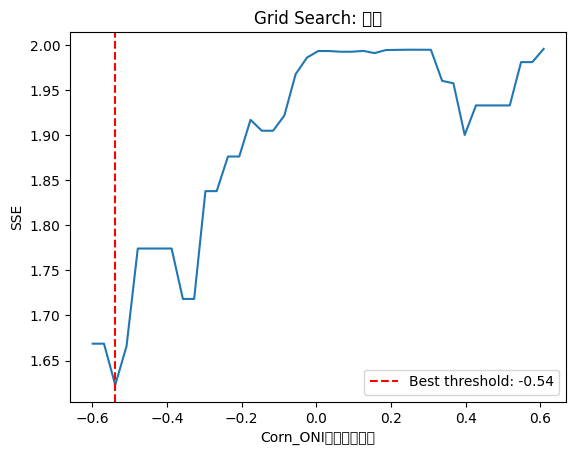

In [175]:
    # 畫圖
    plt.plot(candidate_thresholds, sse_list)
    plt.axvline(best_thr, color='r', linestyle='--', label=f'Best threshold: {best_thr:.2f}')
    plt.xlabel('Corn_ONI（門檻變數）')
    plt.ylabel('SSE')
    plt.title('Grid Search: 玉米')
    plt.legend()
    plt.show()


In [176]:
data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []

In [177]:
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

sse_list = np.array(sse_list)
min_sse = np.nanmin(sse_list)
best_thr = candidate_thresholds[np.nanargmin(sse_list)]
print(f'最佳門檻值：{best_thr:.4f}')

最佳門檻值：-0.5388


In [178]:
# 分組回歸係數
regime1 = data[data[thresh_col] <= best_thr]
regime2 = data[data[thresh_col] > best_thr]
X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
y1 = regime1[y_col]
model1 = OLS(y1, X1).fit()
X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
y2 = regime2[y_col]
model2 = OLS(y2, X2).fit()

print("\nRegime 1 (低於門檻):")
print(model1.summary())
print("\nRegime 2 (高於門檻):")
print(model2.summary())


Regime 1 (低於門檻):
                                OLS Regression Results                               
Dep. Variable:     Corn Quantity Growth Rate   R-squared:                       0.006
Model:                                   OLS   Adj. R-squared:                 -0.192
Method:                        Least Squares   F-statistic:                   0.03248
Date:                       Thu, 12 Jun 2025   Prob (F-statistic):              0.968
Time:                               12:43:47   Log-Likelihood:                 4.6328
No. Observations:                         13   AIC:                            -3.266
Df Residuals:                             10   BIC:                            -1.571
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


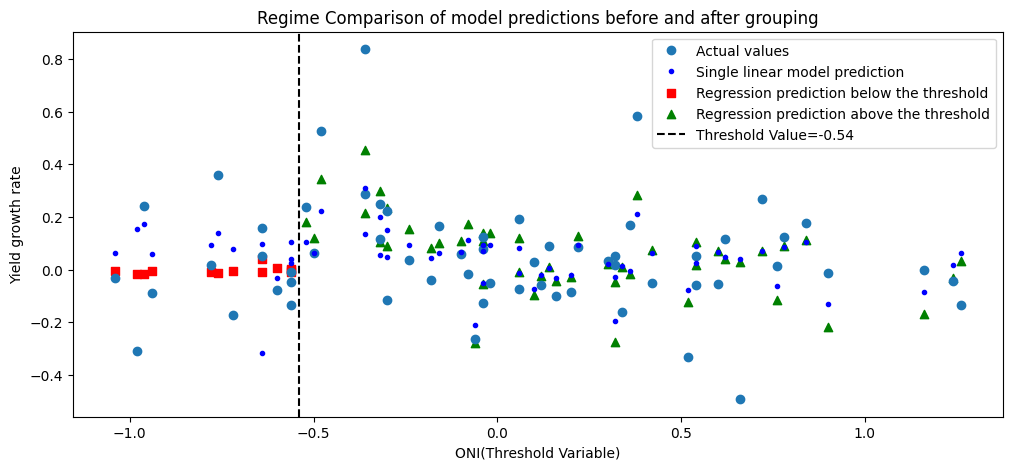

In [179]:
# 單一線性模型
X_all = sm.add_constant(data[[y_lag1_col, thresh_col]])
model_all = OLS(data[y_col], X_all).fit()

plt.figure(figsize=(12,5))
plt.plot(data[thresh_col], data[y_col], 'o', label='Actual values')
plt.plot(data[thresh_col], model_all.predict(X_all), 'b.', label='Single linear model prediction')

plt.scatter(regime1[thresh_col], model1.predict(sm.add_constant(regime1[[y_lag1_col, thresh_col]])),
            color='r', marker='s', label='Regression prediction below the threshold')
plt.scatter(regime2[thresh_col], model2.predict(sm.add_constant(regime2[[y_lag1_col, thresh_col]])),
            color='g', marker='^', label='Regression prediction above the threshold')
plt.axvline(best_thr, color='k', linestyle='--', label=f'Threshold Value={best_thr:.2f}')
plt.xlabel('ONI(Threshold Variable)')
plt.ylabel('Yield growth rate')
plt.legend()
plt.title('Regime Comparison of model predictions before and after grouping')
plt.show()

In [180]:
# 無門檻模型 SSE
S0 = ((data[y_col] - model_all.predict(X_all))**2).sum()
# 門檻模型 SSE
S1 = min_sse
n = len(data)
sigma2 = S1 / n
F_stat = (S0 - S1) / sigma2
print(f"Hansen/LR檢定統計量 F = {F_stat:.3f}")

Hansen/LR檢定統計量 F = 15.064


In [181]:
# Bootstrap 產生對應的 F_stat
n_bootstrap = 300
F_stat_bootstrap = []
np.random.seed(42)
for i in range(n_bootstrap):
    data_shuf = data.copy()
    data_shuf[y_col] = np.random.permutation(data_shuf[y_col].values)
    # 單一線性模型
    X_all_b = sm.add_constant(data_shuf[[y_lag1_col, thresh_col]])
    model_all_b = OLS(data_shuf[y_col], X_all_b).fit()
    S0_b = ((data_shuf[y_col] - model_all_b.predict(X_all_b))**2).sum()
    # 門檻 grid search
    sse_list_b = []
    for thr in candidate_thresholds:
        regime1_b = data_shuf[data_shuf[thresh_col] <= thr]
        regime2_b = data_shuf[data_shuf[thresh_col] > thr]
        if len(regime1_b) < 10 or len(regime2_b) < 10:
            sse_list_b.append(np.nan)
            continue
        X1_b = sm.add_constant(regime1_b[[y_lag1_col, thresh_col]])
        y1_b = regime1_b[y_col]
        model1_b = OLS(y1_b, X1_b).fit()
        sse1_b = ((y1_b - model1_b.predict(X1_b))**2).sum()
        X2_b = sm.add_constant(regime2_b[[y_lag1_col, thresh_col]])
        y2_b = regime2_b[y_col]
        model2_b = OLS(y2_b, X2_b).fit()
        sse2_b = ((y2_b - model2_b.predict(X2_b))**2).sum()
        sse_total_b = sse1_b + sse2_b
        sse_list_b.append(sse_total_b)
    sse_list_b = np.array(sse_list_b)
    if not np.all(np.isnan(sse_list_b)):
        S1_b = np.nanmin(sse_list_b)
        sigma2_b = S1_b / n
        F_b = (S0_b - S1_b) / sigma2_b
        F_stat_bootstrap.append(F_b)

F_stat_bootstrap = np.array(F_stat_bootstrap)
if len(F_stat_bootstrap) > 0:
    p_value_F = (F_stat_bootstrap >= F_stat).mean()
    print(f"Hansen/LR p-value = {p_value_F:.3f}")
else:
    print("❗ 無法計算 bootstrap LR統計量")

Hansen/LR p-value = 0.097


##第二個門檻

In [182]:
# 假設你前面已經載入 df
# 以玉米為例
y_col = 'Corn Quantity Growth Rate'
y_lag1_col = 'lag_corn_quantity_rate'
thresh_col = 'Corn_ONI'
data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)

# 先選擇候選門檻範圍（例如10%~90%分位）
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 30)

# 設定最小 regime 資料數
min_regime = 10

# 雙門檻 grid search
best_sse = np.inf
best_thr1, best_thr2 = None, None

In [183]:
for i, thr1 in enumerate(candidate_thresholds[:-1]):
    for thr2 in candidate_thresholds[i+1:]:
        # regime1: x <= thr1
        # regime2: thr1 < x <= thr2
        # regime3: x > thr2
        regime1 = data[data[thresh_col] <= thr1]
        regime2 = data[(data[thresh_col] > thr1) & (data[thresh_col] <= thr2)]
        regime3 = data[data[thresh_col] > thr2]
        if min(len(regime1), len(regime2), len(regime3)) < min_regime:
            continue
        # OLS for each regime
        X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
        model1 = OLS(regime1[y_col], X1).fit()
        sse1 = ((regime1[y_col] - model1.predict(X1))**2).sum()

        X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
        model2 = OLS(regime2[y_col], X2).fit()
        sse2 = ((regime2[y_col] - model2.predict(X2))**2).sum()

        X3 = sm.add_constant(regime3[[y_lag1_col, thresh_col]])
        model3 = OLS(regime3[y_col], X3).fit()
        sse3 = ((regime3[y_col] - model3.predict(X3))**2).sum()

        total_sse = sse1 + sse2 + sse3
        if total_sse < best_sse:
            best_sse = total_sse
            best_thr1, best_thr2 = thr1, thr2
            best_regimes = (regime1.index, regime2.index, regime3.index)

print(f"最佳門檻 thr1 = {best_thr1:.4f}, thr2 = {best_thr2:.4f}, 最小SSE = {best_sse:.4f}")
print(f"三個 regime 資料量：", *(len(data.loc[idx]) for idx in best_regimes))

最佳門檻 thr1 = -0.5669, thr2 = -0.2607, 最小SSE = 1.3629
三個 regime 資料量： 10 12 39


In [184]:

# S1：單門檻（以你上一輪找過的最佳門檻）
# -- 若沒有，這裡也可再寫一次 grid search 找到 S1/best_thr
single_sse_list = []
for thr in candidate_thresholds:
    reg1 = data[data[thresh_col] <= thr]
    reg2 = data[data[thresh_col] > thr]
    if len(reg1) < min_regime or len(reg2) < min_regime:
        single_sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(reg1[[y_lag1_col, thresh_col]])
    m1 = OLS(reg1[y_col], X1).fit()
    s1 = ((reg1[y_col] - m1.predict(X1))**2).sum()
    X2 = sm.add_constant(reg2[[y_lag1_col, thresh_col]])
    m2 = OLS(reg2[y_col], X2).fit()
    s2 = ((reg2[y_col] - m2.predict(X2))**2).sum()
    single_sse_list.append(s1 + s2)
single_sse_list = np.array(single_sse_list)
S1 = 1.623
best_thr1_single = candidate_thresholds[np.nanargmin(single_sse_list)]

# S2：最佳雙門檻（前面已找到 best_sse）

# 進行 sup-LR 統計量 for 2nd threshold
n = len(data)
sigma2_2 = best_sse / n
F2 = (S1 - best_sse) / sigma2_2
print(f"單門檻 SSE = {S1:.4f}")
print(sigma2_2)
print(f"雙門檻 Hansen/LR 統計量 F2 = {F2:.3f}")

單門檻 SSE = 1.6230
0.02234298100418517
雙門檻 Hansen/LR 統計量 F2 = 11.640


In [185]:
# Bootstrap，計算 p-value
n_bootstrap = 300
F2_bootstrap = []
np.random.seed(31)
for _ in range(n_bootstrap):
    data_shuf = data.copy()
    data_shuf[y_col] = np.random.permutation(data_shuf[y_col].values)
    # 找單門檻 S1*（和上面類似，僅在 shuffle 資料下找最佳單門檻 SSE）
    single_sse_list_b = []
    for thr in candidate_thresholds:
        reg1 = data_shuf[data_shuf[thresh_col] <= thr]
        reg2 = data_shuf[data_shuf[thresh_col] > thr]
        if len(reg1) < min_regime or len(reg2) < min_regime:
            single_sse_list_b.append(np.nan)
            continue
        X1 = sm.add_constant(reg1[[y_lag1_col, thresh_col]])
        m1 = OLS(reg1[y_col], X1).fit()
        s1 = ((reg1[y_col] - m1.predict(X1))**2).sum()
        X2 = sm.add_constant(reg2[[y_lag1_col, thresh_col]])
        m2 = OLS(reg2[y_col], X2).fit()
        s2 = ((reg2[y_col] - m2.predict(X2))**2).sum()
        single_sse_list_b.append(s1 + s2)
    single_sse_list_b = np.array(single_sse_list_b)
    S1_b = np.nanmin(single_sse_list_b)
    # 找雙門檻 S2*
    best_sse_b = np.inf
    for i, thr1 in enumerate(candidate_thresholds[:-1]):
        for thr2 in candidate_thresholds[i+1:]:
            regime1 = data_shuf[data_shuf[thresh_col] <= thr1]
            regime2 = data_shuf[(data_shuf[thresh_col] > thr1) & (data_shuf[thresh_col] <= thr2)]
            regime3 = data_shuf[data_shuf[thresh_col] > thr2]
            if min(len(regime1), len(regime2), len(regime3)) < min_regime:
                continue
            X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
            m1 = OLS(regime1[y_col], X1).fit()
            s1 = ((regime1[y_col] - m1.predict(X1))**2).sum()
            X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
            m2 = OLS(regime2[y_col], X2).fit()
            s2 = ((regime2[y_col] - m2.predict(X2))**2).sum()
            X3 = sm.add_constant(regime3[[y_lag1_col, thresh_col]])
            m3 = OLS(regime3[y_col], X3).fit()
            s3 = ((regime3[y_col] - m3.predict(X3))**2).sum()
            sse_total = s1 + s2 + s3
            if sse_total < best_sse_b:
                best_sse_b = sse_total
    sigma2_2_b = best_sse_b / n
    F2_b = (S1_b - best_sse_b) / sigma2_2_b
    F2_bootstrap.append(F2_b)

F2_bootstrap = np.array(F2_bootstrap)
p_value_F2 = (F2_bootstrap >= F2).mean()
print(f"雙門檻 Hansen/LR 檢定 p-value = {p_value_F2:.3f}")

雙門檻 Hansen/LR 檢定 p-value = 0.147


# 黃豆


In [186]:
# 設定黃豆欄位名
y_col = 'SoybeanYield Growth Rate'
y_lag1_col = 'lag_soybean_yield_rate'
thresh_col = 'Soybean_ONI'
data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
print(f"黃豆資料數：{len(data)}")

黃豆資料數：61


黃豆最小SSE：0.3929
黃豆最佳門檻：0.3408


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40643 (\N{CJK UNIFIED IDEOGRAPH-9EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35910 (\N{CJK UNIFIED IDEOGRAPH-8C46}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38272 (\N{CJK UNIFIED IDEOGRAPH-9580}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27323 (\N{CJK UNIFIED IDEOGRAPH-6ABB}) missing from font(s) DejaVu Sans.
  fig.canvas

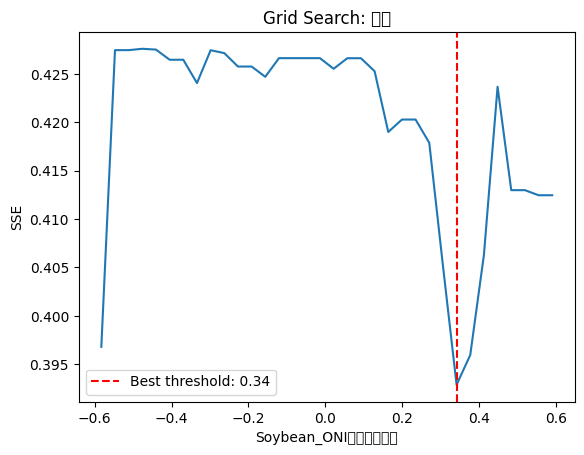

In [187]:
# Grid search 找門檻
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

sse_list = np.array(sse_list)
if np.all(np.isnan(sse_list)):
    print("❗ 沒有合格的 regime 分割（樣本數限制），請調低門檻或檢查資料。")
else:
    min_sse = np.nanmin(sse_list)
    best_thr = candidate_thresholds[np.nanargmin(sse_list)]
    print(f"黃豆最小SSE：{min_sse:.4f}")
    print(f"黃豆最佳門檻：{best_thr:.4f}")

    plt.plot(candidate_thresholds, sse_list)
    plt.axvline(best_thr, color='r', linestyle='--', label=f'Best threshold: {best_thr:.2f}')
    plt.xlabel('Soybean_ONI（門檻變數）')
    plt.ylabel('SSE')
    plt.title('Grid Search: 黃豆')
    plt.legend()
    plt.show()

In [188]:
data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []

In [189]:
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

sse_list = np.array(sse_list)
min_sse = np.nanmin(sse_list)
best_thr = candidate_thresholds[np.nanargmin(sse_list)]
print(f'最佳門檻值：{best_thr:.4f}')

最佳門檻值：0.3408


In [190]:
# 分組回歸係數
regime1 = data[data[thresh_col] <= best_thr]
regime2 = data[data[thresh_col] > best_thr]
X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
y1 = regime1[y_col]
model1 = OLS(y1, X1).fit()
X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
y2 = regime2[y_col]
model2 = OLS(y2, X2).fit()

print("\nRegime 1 (低於門檻):")
print(model1.summary())
print("\nRegime 2 (高於門檻):")
print(model2.summary())


Regime 1 (低於門檻):
                               OLS Regression Results                               
Dep. Variable:     SoybeanYield Growth Rate   R-squared:                       0.188
Model:                                  OLS   Adj. R-squared:                  0.147
Method:                       Least Squares   F-statistic:                     4.633
Date:                      Thu, 12 Jun 2025   Prob (F-statistic):             0.0155
Time:                              12:54:28   Log-Likelihood:                 43.898
No. Observations:                        43   AIC:                            -81.80
Df Residuals:                            40   BIC:                            -76.51
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


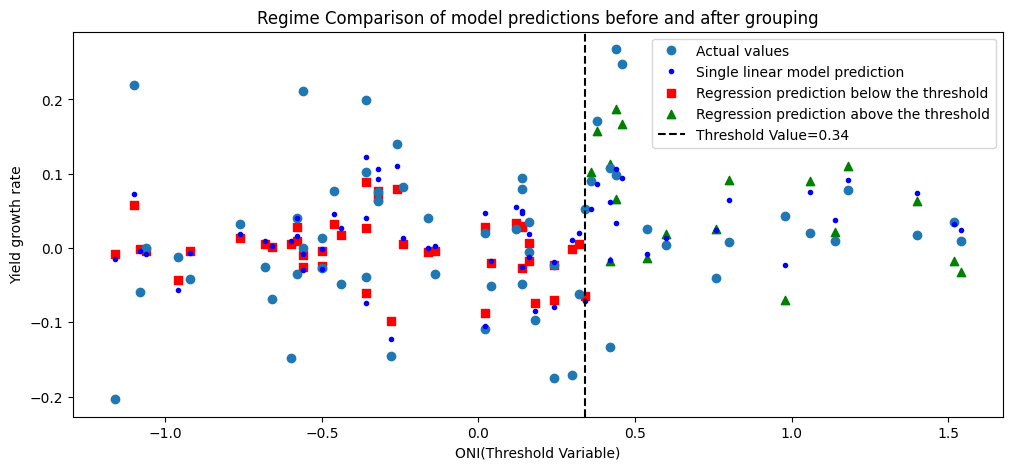

In [191]:
# 單一線性模型
X_all = sm.add_constant(data[[y_lag1_col, thresh_col]])
model_all = OLS(data[y_col], X_all).fit()

plt.figure(figsize=(12,5))
plt.plot(data[thresh_col], data[y_col], 'o', label='Actual values')
plt.plot(data[thresh_col], model_all.predict(X_all), 'b.', label='Single linear model prediction')

plt.scatter(regime1[thresh_col], model1.predict(sm.add_constant(regime1[[y_lag1_col, thresh_col]])),
            color='r', marker='s', label='Regression prediction below the threshold')
plt.scatter(regime2[thresh_col], model2.predict(sm.add_constant(regime2[[y_lag1_col, thresh_col]])),
            color='g', marker='^', label='Regression prediction above the threshold')
plt.axvline(best_thr, color='k', linestyle='--', label=f'Threshold Value={best_thr:.2f}')
plt.xlabel('ONI(Threshold Variable)')
plt.ylabel('Yield growth rate')
plt.legend()
plt.title('Regime Comparison of model predictions before and after grouping')
plt.show()

In [192]:
# 無門檻模型 SSE
S0 = ((data[y_col] - model_all.predict(X_all))**2).sum()
# 門檻模型 SSE
S1 = min_sse
n = len(data)
sigma2 = S1 / n
F_stat = (S0 - S1) / sigma2
print(f"S0 = {S0}")
print(f"S1 = {S1}")
print(f"sigma^2 = {sigma2}")
print(f"Hansen/LR檢定統計量 F = {F_stat:.3f}")

S0 = 0.43372088057133446
S1 = 0.392875787730136
sigma^2 = 0.00644058668410059
Hansen/LR檢定統計量 F = 6.342


In [193]:
# Bootstrap 產生對應的 F_stat
n_bootstrap = 300
F_stat_bootstrap = []
np.random.seed(42)
for i in range(n_bootstrap):
    data_shuf = data.copy()
    data_shuf[y_col] = np.random.permutation(data_shuf[y_col].values)
    # 單一線性模型
    X_all_b = sm.add_constant(data_shuf[[y_lag1_col, thresh_col]])
    model_all_b = OLS(data_shuf[y_col], X_all_b).fit()
    S0_b = ((data_shuf[y_col] - model_all_b.predict(X_all_b))**2).sum()
    # 門檻 grid search
    sse_list_b = []
    for thr in candidate_thresholds:
        regime1_b = data_shuf[data_shuf[thresh_col] <= thr]
        regime2_b = data_shuf[data_shuf[thresh_col] > thr]
        if len(regime1_b) < 10 or len(regime2_b) < 10:
            sse_list_b.append(np.nan)
            continue
        X1_b = sm.add_constant(regime1_b[[y_lag1_col, thresh_col]])
        y1_b = regime1_b[y_col]
        model1_b = OLS(y1_b, X1_b).fit()
        sse1_b = ((y1_b - model1_b.predict(X1_b))**2).sum()
        X2_b = sm.add_constant(regime2_b[[y_lag1_col, thresh_col]])
        y2_b = regime2_b[y_col]
        model2_b = OLS(y2_b, X2_b).fit()
        sse2_b = ((y2_b - model2_b.predict(X2_b))**2).sum()
        sse_total_b = sse1_b + sse2_b
        sse_list_b.append(sse_total_b)
    sse_list_b = np.array(sse_list_b)
    if not np.all(np.isnan(sse_list_b)):
        S1_b = np.nanmin(sse_list_b)
        sigma2_b = S1_b / n
        F_b = (S0_b - S1_b) / sigma2_b
        F_stat_bootstrap.append(F_b)

F_stat_bootstrap = np.array(F_stat_bootstrap)
if len(F_stat_bootstrap) > 0:
    p_value_F = (F_stat_bootstrap >= F_stat).mean()
    print(f"Hansen/LR p-value = {p_value_F:.3f}")
else:
    print("❗ 無法計算 bootstrap LR統計量")

Hansen/LR p-value = 0.617


#小麥

In [194]:
y_col = 'Wheat Quantity Growth Rate'
y_lag1_col = 'lag_wheat_yield_rate'
thresh_col = 'Wheat_ONI'

data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
print(f"小麥資料數：{len(data)}")

小麥資料數：61


小麥最小SSE：0.7661
小麥最佳門檻：0.3117


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40613 (\N{CJK UNIFIED IDEOGRAPH-9EA5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38272 (\N{CJK UNIFIED IDEOGRAPH-9580}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27323 (\N{CJK UNIFIED IDEOGRAPH-6ABB}) missing from font(s) DejaVu Sans.
  fig.canvas

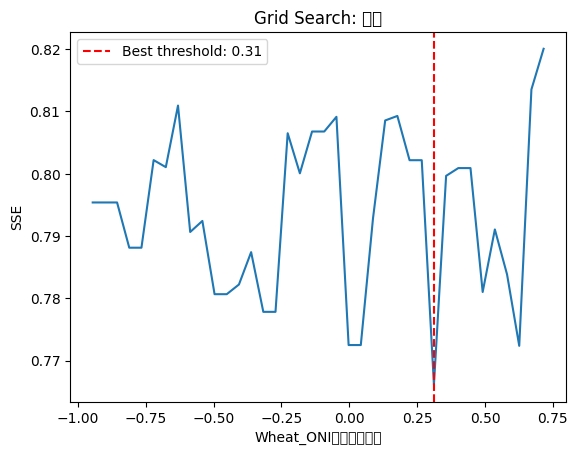

In [195]:
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

sse_list = np.array(sse_list)
if np.all(np.isnan(sse_list)):
    print("❗ 沒有合格的 regime 分割（樣本數限制），請調低門檻或檢查資料。")
else:
    min_sse = np.nanmin(sse_list)
    best_thr = candidate_thresholds[np.nanargmin(sse_list)]
    print(f"小麥最小SSE：{min_sse:.4f}")
    print(f"小麥最佳門檻：{best_thr:.4f}")

    plt.plot(candidate_thresholds, sse_list)
    plt.axvline(best_thr, color='r', linestyle='--', label=f'Best threshold: {best_thr:.2f}')
    plt.xlabel('Wheat_ONI（門檻變數）')
    plt.ylabel('SSE')
    plt.title('Grid Search: 小麥')
    plt.legend()
    plt.show()


In [196]:
data = df[[y_col, y_lag1_col, thresh_col]].dropna().astype(float)
candidate_thresholds = np.linspace(data[thresh_col].quantile(0.10), data[thresh_col].quantile(0.90), 50)
sse_list = []

In [197]:
sse_list = []
for thr in candidate_thresholds:
    regime1 = data[data[thresh_col] <= thr]
    regime2 = data[data[thresh_col] > thr]
    if len(regime1) < 10 or len(regime2) < 10:
        sse_list.append(np.nan)
        continue
    X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
    y1 = regime1[y_col]
    model1 = OLS(y1, X1).fit()
    sse1 = ((y1 - model1.predict(X1))**2).sum()
    X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
    y2 = regime2[y_col]
    model2 = OLS(y2, X2).fit()
    sse2 = ((y2 - model2.predict(X2))**2).sum()
    sse_total = sse1 + sse2
    sse_list.append(sse_total)

# for 迴圈之後才做這個
sse_list = np.array(sse_list)
min_sse = np.nanmin(sse_list)
best_thr = candidate_thresholds[np.nanargmin(sse_list)]
print(f'最佳門檻值：{best_thr:.4f}')

最佳門檻值：0.3117


In [198]:
# 分組回歸係數
regime1 = data[data[thresh_col] <= best_thr]
regime2 = data[data[thresh_col] > best_thr]
X1 = sm.add_constant(regime1[[y_lag1_col, thresh_col]])
y1 = regime1[y_col]
model1 = OLS(y1, X1).fit()
X2 = sm.add_constant(regime2[[y_lag1_col, thresh_col]])
y2 = regime2[y_col]
model2 = OLS(y2, X2).fit()

print("\nRegime 1 (低於門檻):")
print(model1.summary())
print("\nRegime 2 (高於門檻):")
print(model2.summary())


Regime 1 (低於門檻):
                                OLS Regression Results                                
Dep. Variable:     Wheat Quantity Growth Rate   R-squared:                       0.127
Model:                                    OLS   Adj. R-squared:                  0.077
Method:                         Least Squares   F-statistic:                     2.538
Date:                        Thu, 12 Jun 2025   Prob (F-statistic):             0.0935
Time:                                12:55:31   Log-Likelihood:                 27.427
No. Observations:                          38   AIC:                            -48.85
Df Residuals:                              35   BIC:                            -43.94
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

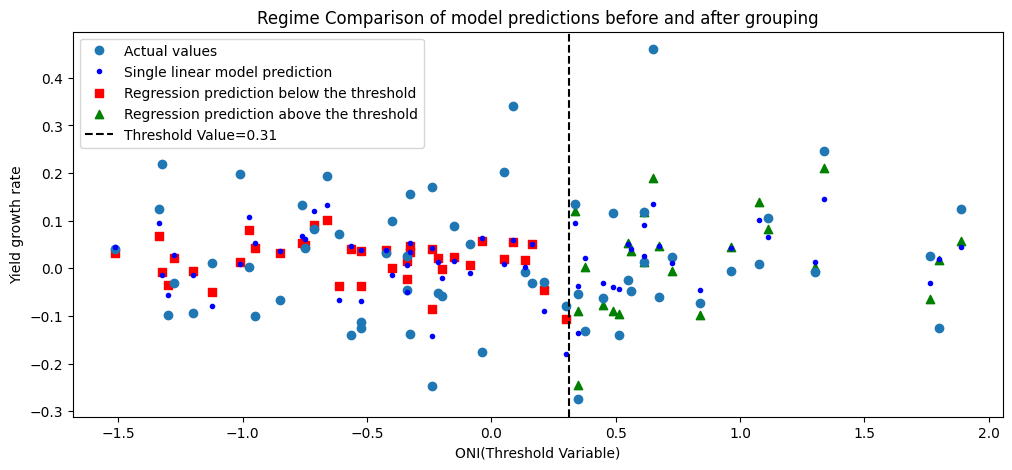

In [199]:
# 單一線性模型
X_all = sm.add_constant(data[[y_lag1_col, thresh_col]])
model_all = OLS(data[y_col], X_all).fit()

plt.figure(figsize=(12,5))
plt.plot(data[thresh_col], data[y_col], 'o', label='Actual values')
plt.plot(data[thresh_col], model_all.predict(X_all), 'b.', label='Single linear model prediction')

plt.scatter(regime1[thresh_col], model1.predict(sm.add_constant(regime1[[y_lag1_col, thresh_col]])),
            color='r', marker='s', label='Regression prediction below the threshold')
plt.scatter(regime2[thresh_col], model2.predict(sm.add_constant(regime2[[y_lag1_col, thresh_col]])),
            color='g', marker='^', label='Regression prediction above the threshold')
plt.axvline(best_thr, color='k', linestyle='--', label=f'Threshold Value={best_thr:.2f}')
plt.xlabel('ONI(Threshold Variable)')
plt.ylabel('Yield growth rate')
plt.legend()
plt.title('Regime Comparison of model predictions before and after grouping')
plt.show()

In [200]:
# 無門檻模型 SSE
S0 = ((data[y_col] - model_all.predict(X_all))**2).sum()
# 門檻模型 SSE
S1 = min_sse
n = len(data)
sigma2 = S1 / n
F_stat = (S0 - S1) / sigma2
print(f"S0 = {S0}")
print(f"S1 = {S1}")
print(f"sigma^2 = {sigma2}")
print(f"Hansen/LR檢定統計量 F = {F_stat:.3f}")

S0 = 0.8233896985698448
S1 = 0.7661131035510944
sigma^2 = 0.012559231205755646
Hansen/LR檢定統計量 F = 4.561


In [201]:
# Bootstrap 產生對應的 F_stat
n_bootstrap = 300
F_stat_bootstrap = []
np.random.seed(42)
for i in range(n_bootstrap):
    data_shuf = data.copy()
    data_shuf[y_col] = np.random.permutation(data_shuf[y_col].values)
    # 單一線性模型
    X_all_b = sm.add_constant(data_shuf[[y_lag1_col, thresh_col]])
    model_all_b = OLS(data_shuf[y_col], X_all_b).fit()
    S0_b = ((data_shuf[y_col] - model_all_b.predict(X_all_b))**2).sum()
    # 門檻 grid search
    sse_list_b = []
    for thr in candidate_thresholds:
        regime1_b = data_shuf[data_shuf[thresh_col] <= thr]
        regime2_b = data_shuf[data_shuf[thresh_col] > thr]
        if len(regime1_b) < 10 or len(regime2_b) < 10:
            sse_list_b.append(np.nan)
            continue
        X1_b = sm.add_constant(regime1_b[[y_lag1_col, thresh_col]])
        y1_b = regime1_b[y_col]
        model1_b = OLS(y1_b, X1_b).fit()
        sse1_b = ((y1_b - model1_b.predict(X1_b))**2).sum()
        X2_b = sm.add_constant(regime2_b[[y_lag1_col, thresh_col]])
        y2_b = regime2_b[y_col]
        model2_b = OLS(y2_b, X2_b).fit()
        sse2_b = ((y2_b - model2_b.predict(X2_b))**2).sum()
        sse_total_b = sse1_b + sse2_b
        sse_list_b.append(sse_total_b)
    sse_list_b = np.array(sse_list_b)
    if not np.all(np.isnan(sse_list_b)):
        S1_b = np.nanmin(sse_list_b)
        sigma2_b = S1_b / n
        F_b = (S0_b - S1_b) / sigma2_b
        F_stat_bootstrap.append(F_b)

F_stat_bootstrap = np.array(F_stat_bootstrap)
if len(F_stat_bootstrap) > 0:
    p_value_F = (F_stat_bootstrap >= F_stat).mean()
    print(f"Hansen/LR p-value = {p_value_F:.3f}")
else:
    print("❗ 無法計算 bootstrap LR統計量")

Hansen/LR p-value = 0.860
